# Lane lines detection

### Imports

In [109]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from IPython import display
%matplotlib inline

# Image processing functions:
### Grayscale an image

In [110]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Apply the Canny transform

In [111]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

### Apply Gaussian blur

In [112]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Apply an image mask
Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black.

In [113]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Returns an image with hough lines drawn.

In [114]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

### Print an image

In [115]:
def print_image(image, title = ''):
    fig = plt.figure()
    if not (title == ''):
        plt.suptitle(title + ':')
    plt.imshow(image, cmap='gray')
    plt.show
    display.display(fig)

# Line functions: interpolation, approximation, filtering,..

### Class for vectors
Every line, detected on the image, will be oriented vector from bottom of the image to top of the image.

In [116]:
class Vector:
    def __init__(self, x1, y1, x2, y2):
        if (y1 > y2):
            self.x1 = x1
            self.y1 = y1 
            self.x2 = x2
            self.y2 = y2
        else:
            self.x1 = x2
            self.y1 = y2 
            self.x2 = x1
            self.y2 = y1
            
        self.alpha = math.atan2(self.y1 - self.y2, self.x1 - self.x2)
        
        self.y0 = 0
        if (x1 != x2):
            self.y0 = (y2*x1-y1*x2)/(x1-x2)
    
    # override to string
    def __repr__(self):  
        return '\n{},{},{},{},{},{}'.format(self.x1, self.y1, self.x2, self.y2, self.alpha, self.y0)
    
    def __str__(self):
        return '\n{},{},{},{},{},{}'.format(self.x1, self.y1, self.x2, self.y2, self.alpha, self.y0)
    
    # override equals for comparing vectors
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return ((self.x1 == other.x1) & (self.x2 == other.x2) & (self.y1 == other.y1) & (self.y2 == other.y2)) 
        return False

    def __ne__(self, other):
        result = self.__eq__(other)
        if result is NotImplemented:
            return result
        return not result

### Sort vectors
Takes an array of vectors and gives output of sorted vectors by starting point from bottom of the image to top of the image. 
I did not find any possibilities to sort an array of classes in numpy, so had to implement it by myself. The algorythm is not optimal, but for this project I guess it should not be a big deal. For production usage some other sorting algorythm should be used.

In [117]:
def sort_vectors(vectors):
    res = np.empty([0])
    unsorted = vectors
    
    # iterating unsorted until we have any vectors there
    while unsorted.size > 0:        
        # define max_vector, so any othe vector will be bigger than this
        max_vector = Vector(-2,-2,-1,-1) 
        
        # iterate over unsorted vectors and find the one with maximum beginning
        for vector in unsorted:
            if vector.y1 > max_vector.y1:
                max_vector = vector
        
        # add max to the sorted list
        arr = np.concatenate((res, np.array([max_vector])))
        res = arr
        
        # remove added vector from unsorted
        new_unsorted = np.empty([0])
        for vector in unsorted:
            if vector != max_vector:
                arr = np.concatenate((new_unsorted, np.array([vector])))
                new_unsorted = arr
        unsorted = new_unsorted
    return res

### Filter out "bad" lines
Filter out lines that are not eligible to be detected as lane lines:
1. By angle (not a lane line or lane line of a crossing road, we do not need it for this project)
2. By length (hight probability of noise and bad direction)

In [118]:
def filter_vectors_by_angle_and_length(vectors,min_threshold,max_threshold, length_threshold):
    # filter out lines that are for sure not lane lines by angle and sort by y (to make vectors from bottom to top)
    res = np.empty([0])
    for vector in vectors:
        # get length
        length = math.sqrt((vector.y1-vector.y2)**2 + (vector.y1-vector.y2)**2)
        
        # filtering
        if ((vector.alpha >= min_threshold) & (vector.alpha <= max_threshold) & ( length > length_threshold)): 
            arr = np.concatenate((res, np.array([vector])))
            res = arr
    return res

### Calculate distanse between line and point

In [119]:
def get_perpendicular_distance(vector_alpha, vector_y0, x, y):
    # get projection on line by y
    vector_y = math.tan(vector_alpha)*x + vector_y0
    
    # get perpendicular projection on the line
    h = abs((y - vector_y)*math.cos(vector_alpha))
    return h

### Group vectors into lane lines
Group vectors that has similar angle and small distance between lines, so one group probably describes one lane line.

In [120]:
def group_vectors(vectors, delta_alpha, delta_h):
    # returns array of arrays: (max y, min y, fill, i, sumAlpha, sumY0, array[Vectors])
    grouped_vectors = np.empty([0,7])
    
    # iterate over all vectors
    for vector in vectors:
        # variable for checking if vector has been added to an existing group
        added = False
        
        # get some vector properies
        y1 = vector.y1
        y2 = vector.y2
        x1 = vector.x1
        x2 = vector.x2
        alpha = vector.alpha
        y0 = vector.y0
        
        # add vector to ANY group of vectors, that looks similar. Each vector could be added to several groups.
        temp_array = np.empty([0,7])
        for average in grouped_vectors:
            
            # get some group properties
            y1_avg = average.item(0)
            y2_avg = average.item(1)
            fill_avg = average.item(2)
            i_avg = average.item(3)
            sum_alpha_avg = average.item(4)
            sum_y0_avg = average.item(5)
            vectors_avg = average.item(6)
            
            # calculate diestance from beginning and end of the vector to the line
            h1 = get_perpendicular_distance(sum_alpha_avg/i_avg, sum_y0_avg/i_avg, x1, y1)
            h2 = get_perpendicular_distance(sum_alpha_avg/i_avg, sum_y0_avg/i_avg, x2, y2)
            
            # check if vector should belong to the group
            similar_angle = (abs(alpha - sum_alpha_avg/i_avg) < delta_alpha)
            similar_h = ((h2 < delta_h) | (h1 < delta_h))
            similar = (similar_angle & similar_h)
            
            # add to the group if similar, skip if not
            if similar:
                vectors_array = np.concatenate((vectors_avg, np.array([vector])))
                arr = np.concatenate((temp_array, np.array([[max(y1,y1_avg),min(y2,y2_avg),fill_avg + y1 - y2,i_avg + 1,sum_alpha_avg + alpha,sum_y0_avg + y0,vectors_array]])))
                temp_array = arr
                added = True            
            else:
                arr = np.concatenate((temp_array, np.array([[y1_avg,y2_avg,fill_avg,i_avg,sum_alpha_avg,sum_y0_avg,vectors_avg]])))
                temp_array = arr
        grouped_vectors = temp_array
        
        # create a new group if vector could not be placed in any of the existing groups
        if not added:
            i = 1
            arr = np.concatenate((grouped_vectors, np.array([[y1,y2,y1 - y2,1,alpha,y0,np.array([vector])]])))
            grouped_vectors = arr
    return grouped_vectors

### Filter out "bad" lane lines
Filter out lane lines that are probably not lane lines by two parameters:
1. Total length of the lane line including spaces in between is less than some value - probably not a lane line, just some line.
2. Fillrate of the lane line is lower that some threshold - probably not a lane line, just set of unconnected in real life lines. Fillrate is total length of all projections of lines on y devided by projection of a lane on y. Lane y borders are maximum and minimum y from all lines in the group. For solid lane lines fillrate is around 200% because every lane line contains two lines = left and right.

In [121]:
def filter_lane_lines(vector_groups, lane_length_threshold, lane_fillrate_threshold):
    res = np.empty([0,7])
    for vector_group in vector_groups:
        # get some variables
        y1 = vector_group.item(0)
        y2 = vector_group.item(1)
        
        # get lane line fillrate
        fill = vector_group.item(2)
        fillrate = fill*100/(y1 - y2)
        
        # get lane length
        i = vector_group.item(3)
        sum_alpha = vector_group.item(4)
        alpha = sum_alpha / i
        length = (y1 - y2) / math.sin(alpha)
        
        # filter out bad lines
        if ((length > lane_length_threshold) & ( fillrate > lane_fillrate_threshold)):
            arr = np.concatenate((res, np.array([vector_group]))) 
            res = arr

    return res 

### Define weighted average vector for the group of lines

In [122]:
def get_average_vectors(vector_groups):
    res = np.empty([0])
    
    # get average vector for every group
    for vector_group in vector_groups: 
        
        # get some group properties
        y1 = vector_group.item(0)
        y2 = vector_group.item(1)
        fill = vector_group.item(2)
        vectors = vector_group.item(6)
        
        # init variables
        x_min = 100000
        x_max = 0
        avg_alpha = 0
        avg_y0 = 0
        
        # iterate over vectors and calculate weighted alpha and y0
        for vector in vectors:
            avg_alpha = avg_alpha + (vector.y1-vector.y2) * vector.alpha/fill
            avg_y0 = avg_y0 + (vector.y1-vector.y2) * vector.y0/fill
            
            # get also minimal and maximal x for horizontal lines 
            # I filter them out in this solution on a previous steps, but may use in future
            x_min = min(vector.x1,x_min)
            x_min = min(vector.x2,x_min)
            x_max = max(vector.x1,x_max)
            x_max = max(vector.x2,x_max)
            
        # add average vector to the group
        horizontal = (math.tan(avg_alpha) == 0)
        if horizontal:
            arr = np.concatenate((res,np.array([Vector(x_min,y1,x_max,y2)])))
            res = arr 
        else:
            x1 = (y1 - avg_y0)/math.tan(avg_alpha)
            x2 = (y2 - avg_y0)/math.tan(avg_alpha)
            arr = np.concatenate((res,np.array([Vector(x1,y1,x2,y2)])))
            res = arr 
    return res

### Graw lines on the image

In [123]:
def graw_lines(lines, line_img):
    # iterate over all lines and draw them
    for line in lines:
        x1 = line.x1
        y1 = line.y1
        x2 = line.x2
        y2 = line.y2

        img_shape = line_img.shape
        resX = img_shape[1]
        resY = img_shape[0]
        
        # extend lane lines to bottom if they are closed to it
        closed_to_bottom_threshold = (y1-y2)*3
        closed_to_bottom = ((resY - y1) < closed_to_bottom_threshold)
        if closed_to_bottom:
            y1 = resY
            horizontal = (math.tan(line.alpha) == 0)
            if not horizontal:
                x1 = (y1 - line.y0)/math.tan(line.alpha) 
             
        cv2.line(line_img,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),10)

    return line_img

# Main image processing code
where the magic happens...

In [131]:
def process_image(image):
    # read in an image
    source_img = image

    # print out stats and plotting
    img_shape = source_img.shape
    # print('Source image: ', type(source_img), ' with dimensions:', img_shape)

    # get image resolution for later usage to become universal for any size of the input image
    resX = img_shape[1]
    resY = img_shape[0]

    # grayscale an image
    grayscale_img = grayscale(source_img)

    # Gaussain smoothing
    kernel_size = 5
    gaussian_gray_img = gaussian_blur(grayscale_img, kernel_size)

    # Canny transform
    low_threshold = 70
    high_threshold = 200
    canny_img = canny(gaussian_gray_img, low_threshold, high_threshold)

    # Add masc (four sided polygon)
    deltaX = round(resX*3/100) # 3% of image width, so poly upper line will be 3*2% length of x resolution
    deltaY = round(resY*10/100) # 10% of image height, so poly upper line will be 10% down from the middle of the image 
    verticles = np.array([[(0,resY),(resX/2 - deltaX, resY/2 + deltaY), 
                           (resX/2 + deltaX, resY/2 + deltaY), (resX,resY)]], dtype=np.int32)
    masked_img = region_of_interest(canny_img, verticles)

    # Run Hough transform
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 # minimum number of pixels making up a line
    max_line_gap = 35    # maximum gap in pixels between connectable line segments

    lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # creating a blank to draw lines on
    line_img = np.copy(source_img)*0 
    
    # create array of vectors from Hough lines
    vectors = np.empty([0])
    for line in lines:
        for x1,y1,x2,y2 in line:
            arr = np.concatenate((vectors, np.array([Vector(x1,y1,x2,y2)])))
            vectors = arr
            
            # uncomment following line to see Hough results on the output
            # cv2.line(line_img,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),10)

    # filter vectors by angle and length, all numbers are intuitive
    min_angle = 0.35
    max_angle = 2.8
    min_line_length = resY/10 
    filtered_vectors = filter_vectors_by_angle_and_length(vectors, min_angle, max_angle, min_line_length)
    
    # sort vectors to itarate over them from bottom to top of the image
    sorted_vectors = sort_vectors(filtered_vectors)
    
    # group vectors into similar groups by linear average, all numbers are intuitive
    angle_threshold = 0.3
    distanse_threshold = resY/10
    grouped_vectors = group_vectors(sorted_vectors, angle_threshold, distanse_threshold)
    
    # filter out groups that are probably not a lane lines, all numbers are intuitive
    min_lane_length = resY/20
    min_fillrate = 90
    filtered_lane_lines = filter_lane_lines(grouped_vectors, min_lane_length, min_fillrate)
    
    # get lane lines from each group by weighted average 
    lane_lines = get_average_vectors(filtered_lane_lines)
 
    # draw lanes lines on one layer
    lane_line_img = graw_lines(lane_lines, line_img)

    # draw the lane lines on the input image
    lines_edges = cv2.addWeighted(source_img, 0.8, lane_line_img, 1, 0) 
    
    # print_image(lines_edges, 'Img')
    return lines_edges

# Process materials

### Helper function for photo processing

In [125]:
def process_one_photo(image_name):
    image = mpimg.imread('test_images/' + image_name)
    res = process_image(image)
    print_image(res)
    # fig, ax = plt.subplots(res)
    # fig.savefig('images_output/' + image_name)

### Sample photos

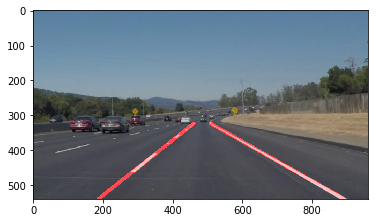

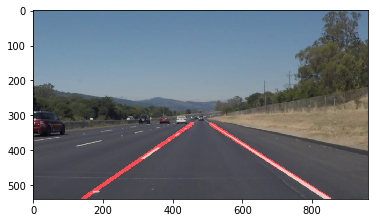

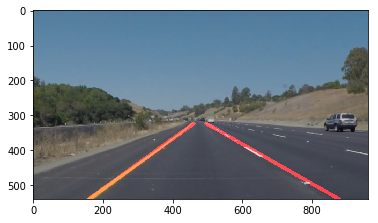

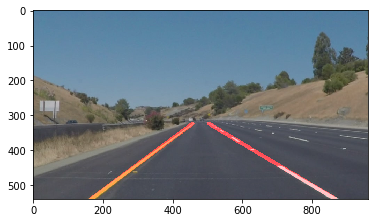

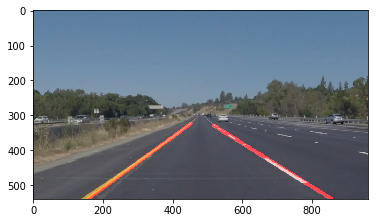

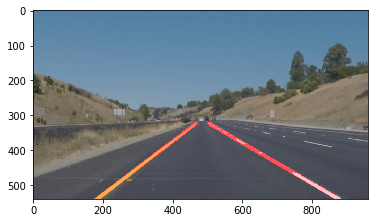

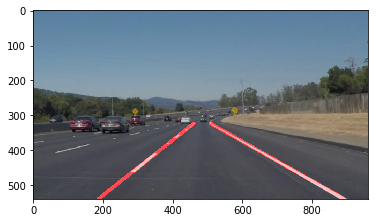

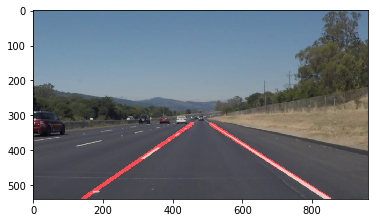

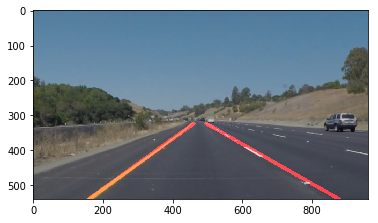

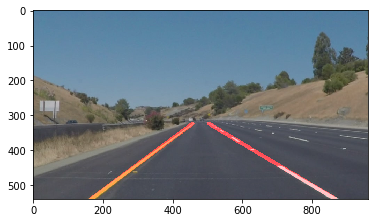

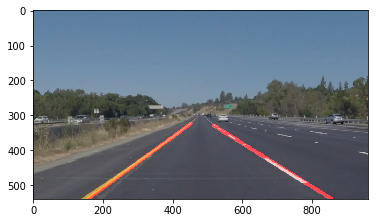

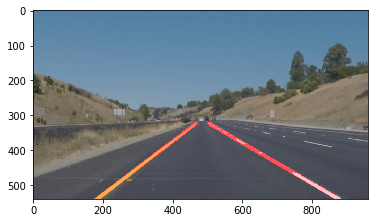

In [126]:
process_one_photo('solidWhiteCurve.jpg')
process_one_photo('solidWhiteRight.jpg')
process_one_photo('solidYellowCurve.jpg')
process_one_photo('solidYellowCurve2.jpg')
process_one_photo('solidYellowLeft.jpg')
process_one_photo('whiteCarLaneSwitch.jpg')

### Sample videos

In [127]:
fname = 'solidWhiteRight.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip("test_videos/" + fname)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

fname = 'solidYellowLeft.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip("test_videos/" + fname)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

### Challenge

In [ ]:
fname = 'challenge.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip("test_videos/" + fname)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)